In [1]:
using Dates; now()

2020-05-20T14:55:21.95

In [2]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_LOAD_PATH = :/home/mforets/Tools/GMSH/gmsh-4.5.4-Linux64-sdk/lib
  JULIA_NUM_THREADS = 4


## Generating the data

In [3]:
using ReachabilityAnalysis, Plots
const RA = ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


ReachabilityAnalysis

In [4]:
B = Ball2([1.0, 1.0], 0.15);
B_ext = overapproximate(B, 1e-2)
B_int = underapproximate(B, PolarDirections(10))
B_int = tohrep(convert(VPolygon, B_int)) # cast to Hrep
I⁻ = complement(B_int) # source invariant
I⁺ = B_ext # target invariant
G = B_ext # guard
transition = DiscreteTransition(guard=G, source_invariant=I⁻, target_invariant=I⁺)

@taylorize function lotka_volterra!(du, u, p, t)
    du[1] = u[1] * (3.0 - 3.0*u[2])
    du[2] = -u[2] * (1.0 - 1.0*u[1])
    return du
end

# initial states
ε = 0.008
X0 = Hyperrectangle(low=[1.3-ε, 1.], high=[1.3+ε, 1.]);

# initial-value problem
prob = @ivp(x' = lotka_volterra!(x), dim: 2, x(0) ∈ X0);
sol = solve(prob, tspan=(0.0, 3.64), TMJets(abs_tol=1e-17,orderT=7,orderQ=1));
solz = overapproximate(sol, Zonotope);

# identity reach-sets that intersect the guard
using ReachabilityAnalysis: _is_intersection_empty
LazySets.set_ztol(Float64, 1e-14)

L = Vector{rsetrep(solz)}()
jump_idx = Vector{Int64}()
for (i, X) in enumerate(solz)
    _is_intersection_empty(X, G) && continue
    push!(L, X)
    push!(jump_idx, i)
end

## Results

Plot the first flowpipe:

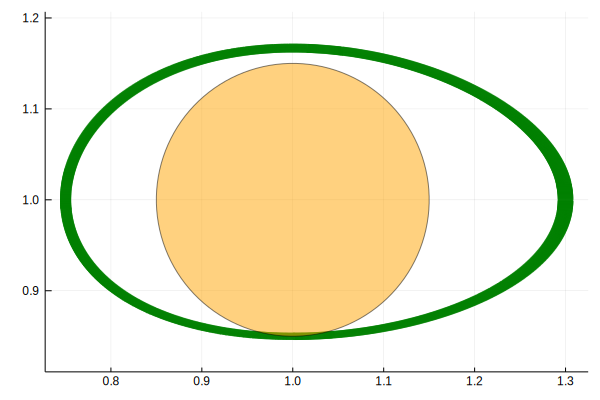

In [5]:
fig = plot()
plot!(fig, solz,  vars=(1, 2), linecolor=:green, color=:green, alpha=0.8, ratio=1.0)
plot!(B, 1e-4, color=:orange)

Plot only the reach-sets that intersect the guard:

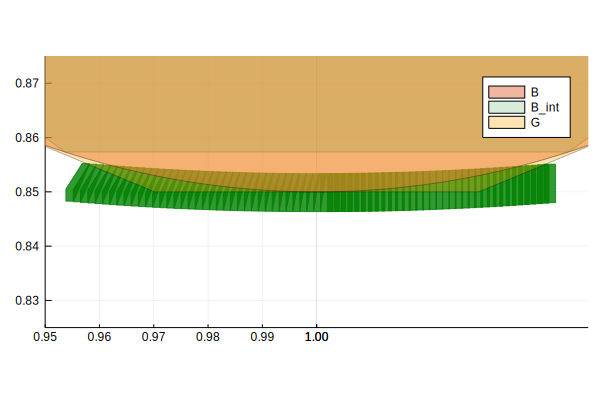

In [6]:
fig = plot()
plot!(fig, L, vars=(1, 2), linecolor=:green, color=:green, alpha=0.8, ratio=1.0)
plot!(B, 1e-5, lab="B")
plot!(B_int, lab="B_int", alpha=.2)
plot!(G, lab="G", ylims=(0.825, 0.875), xlims=(0.95, 1.05), color=:orange, alpha=.3)

## Taylor models which intersect the guard

The Taylor models which intersect the guard are those from the solution `sol` with indices `jump_idx`. There are 71 such reach-sets as shown below.

In [8]:
@show length(jump_idx)
@show first(jump_idx)
@show last(jump_idx)

length(jump_idx) = 71
first(jump_idx) = 1004
last(jump_idx) = 1074


1074

The taylor models which intresect the guard are `sol[jump_idx]`:

In [27]:
L = sol[jump_idx];
length(L)

71

For instance, let $R_5$ be the fifth reach-set which intersects the guard.

In [30]:
R5 = L[5]

TaylorModelReachSet{Float64}(TaylorModels.TaylorModel1{TaylorN{Float64},Float64}[  0.9605878310746825 - 0.0014021170656929574 x₁ + ( 0.42833114237279546 + 0.00921605702703403 x₁) t + ( 0.14384509443778631 + 0.005704377151402227 x₁) t² + ( - 0.14002936495475804 - 0.0007500124209421108 x₁) t³ + ( - 0.0950026876507271 - 0.003226403940316134 x₁) t⁴ + ( - 0.02895719581066939 - 0.002320833225909401 x₁) t⁵ + ( 0.012525062964639866 - 0.00028984148768216596 x₁) t⁶ + ( 0.015084498689582972 + 0.0005457402579197882 x₁) t⁷ + [-1.38728e-15, 1.38407e-15],   0.8513649217293717 - 0.0034150159753170532 x₁ + ( - 0.033554138112287725 - 0.0010591200993872475 x₁) t + ( 0.18299427542994617 + 0.0032361295127432297 x₁) t² + ( 0.03362672798753272 + 0.0010727533532003692 x₁) t³ + ( - 0.011746460685330322 + 0.0006197765365697581 x₁) t⁴ + ( - 0.006998846789522894 + 4.374979925955243e-6 x₁) t⁵ + ( - 0.00783474582507104 - 0.0002909208717451707 x₁) t⁶ + ( - 0.002119622117045148 - 0.00018175922158330976 x₁) t⁷ + [-3.8

In [31]:
tspan(R5) # time-span of this reach-st

[2.6663, 2.66935]

In [33]:
set(R5) # vector of taylor models (one for each coordinate) in one variable ("time") whose coefficients are 
# taylor series in N=2 variables ("space" variables), whose domain is normalized on the symmetric interval
# [-1, 1]

2-element Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},1}:
              0.9605878310746825 - 0.0014021170656929574 x₁ + ( 0.42833114237279546 + 0.00921605702703403 x₁) t + ( 0.14384509443778631 + 0.005704377151402227 x₁) t² + ( - 0.14002936495475804 - 0.0007500124209421108 x₁) t³ + ( - 0.0950026876507271 - 0.003226403940316134 x₁) t⁴ + ( - 0.02895719581066939 - 0.002320833225909401 x₁) t⁵ + ( 0.012525062964639866 - 0.00028984148768216596 x₁) t⁶ + ( 0.015084498689582972 + 0.0005457402579197882 x₁) t⁷ + [-1.38728e-15, 1.38407e-15]
   0.8513649217293717 - 0.0034150159753170532 x₁ + ( - 0.033554138112287725 - 0.0010591200993872475 x₁) t + ( 0.18299427542994617 + 0.0032361295127432297 x₁) t² + ( 0.03362672798753272 + 0.0010727533532003692 x₁) t³ + ( - 0.011746460685330322 + 0.0006197765365697581 x₁) t⁴ + ( - 0.006998846789522894 + 4.374979925955243e-6 x₁) t⁵ + ( - 0.00783474582507104 - 0.0002909208717451707 x₁) t⁶ + ( - 0.002119622117045148 - 0.00018175922158330976 x₁) t⁷ + [-

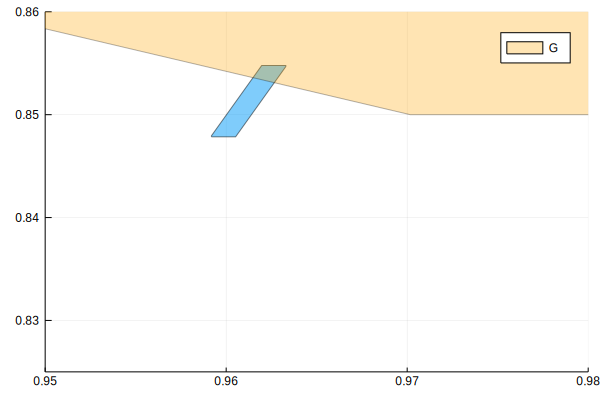

In [34]:
plot(overapproximate(R5, Zonotope), vars=(1, 2))
plot!(G, lab="G", ylims=(0.825, 0.86), xlims=(0.95, 0.98), color=:orange, alpha=.3)